#### Metadata analysis of PDX data

##### Load the packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Use the 'create_ExpData.py' code to generate pseudoraw counts and run limma voom normalisation to
get normalised counts.

In [2]:
# read the normalised expression data
pdx_exp = pd.read_csv('../data/pdx_data/pseudoRawCounts.csv',
                   header = 0, index_col = 0)
pdx_exp = pdx_exp.T
pdx_exp.head()

Sample,A1BG,A1BG-AS1,A1CF,A2M,A2ML1,A2MP1,A4GALT,A4GNT,AAAS,AACS,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
X-1004,654.0,527.0,49.0,14.0,0.0,0.0,100.0,0.0,9679.0,99506.0,...,0.0,6912.0,152.0,712.0,9284.0,19255.0,30843.0,10971.0,17342.0,76059.0
X-1008,2133.0,690.0,74.0,98753.0,1125.0,14.0,1025.0,72.0,5446.0,35166.0,...,0.0,6511.0,410.0,1346.0,9864.0,6283.0,29892.0,56257.0,26131.0,29663.0
X-1027,33.0,0.0,3204.0,0.0,0.0,0.0,1817.0,0.0,13623.0,42181.0,...,0.0,7296.0,79.0,369.0,8857.0,0.0,8302.0,24874.0,15164.0,30804.0
X-1095,31.0,0.0,6975.0,5120.0,74.0,0.0,534.0,0.0,17950.0,47103.0,...,0.0,2293.0,49.0,312.0,10663.0,105.0,5909.0,10836.0,13224.0,28211.0
X-1119,19.0,0.0,7074.0,0.0,18.0,0.0,0.0,2.0,12514.0,30778.0,...,0.0,3531.0,61.0,416.0,11474.0,0.0,8763.0,35441.0,25062.0,27934.0


In [3]:
pdx_exp.shape 

(399, 19664)

In [4]:
dataset_path = "../data/pdx_data/PDX_tumorSize_drugResponses.xlsx"
# exp_data = pd.read_excel(dataset_path, sheet_name="RNAseq_fpkm", header=0, index_col=0)
pdx_response_data = pd.read_excel(dataset_path, sheet_name="PCT raw data", header=0, index_col=0)

In [5]:
ct = pd.crosstab(pdx_response_data["Tumor Type"], pdx_response_data["Days Post T0"])
# ct = ct / ct.loc[:, 0]
ct_norm = ct.div(ct[0], axis=0)
ct_norm.drop(0, axis=1, inplace=True)
ct_norm.drop(ct_norm.columns[-1], axis=1, inplace=True)

# Define uniform follow-up days
uniform_days = np.arange(0, 101, 5)  # 0, 5, 10, ..., 100

# Reindex columns to these uniform days and interpolate
ct_interp = ct_norm.T  # transpose to make Days the index
ct_interp = ct_interp.reindex(uniform_days).interpolate(method='linear', limit_direction='both')

# (Optional) Rolling average smooth (window size = 3)
ct_smoothed = ct_interp.rolling(window=3, min_periods=1, center=True).mean()

# Transpose back: rows = tumor types, columns = Days
ct_final = ct_smoothed.T

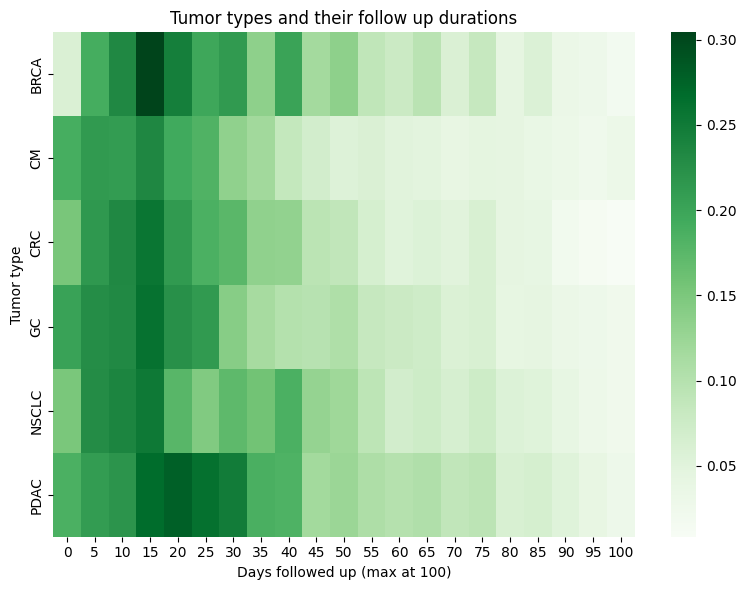

In [6]:
# Plot heatmap
plt.figure(figsize = (8,6))
sns.heatmap(
    ct_final,
    cmap="Greens",          # white-to-green colormap
    linewidths=0,
    linecolor='gray',
    cbar=True,
    yticklabels=True       # hides row names
)

plt.xlabel("Days followed up (max at 100)")
plt.ylabel("Tumor type")              # optional: hides y-axis label
plt.title("Tumor types and their follow up durations")
plt.tight_layout()
plt.show()

As seen from above heatmap, many of the NSCLC samples were followed upto 20 days.

We now subset the data for erlotinib treated patients.

In [7]:
days_followup = list(range(0, 25, 5))
pdx_response_data = pdx_response_data.reset_index()
pdx_response_data["model_treatment"] = pdx_response_data["Model"].astype(str) + "_" + pdx_response_data["Treatment"]

# create a df for tumor volume difference over time
tumor_vol_shrinkage = pd.DataFrame(index = pdx_response_data["model_treatment"].unique(),
                                   columns = [f'T{i}' for i in days_followup])
# tumor_vol_shrinkage.head()
for model_treatment in list(pdx_response_data["model_treatment"].unique()):
  # print(model_treatment)
  model_data = pdx_response_data[pdx_response_data["model_treatment"] == model_treatment]
  # for 1st time point = 0
  if 0 in model_data["Days Post T0"]:
    tumor_vol_shrinkage.loc[model_treatment, "T0"] = model_data[model_data["Days Post T0"] == 0]["% TVol Difference"].values[0]
  for i, time_followup in enumerate(days_followup):
    if i != 0:
      # print(f"time:{time_followup}")
      if (model_data["Days Post T0"] < time_followup).any():
    # summarise based on time followup bins
        step_data = model_data[(model_data["Days Post T0"] != 0) & (model_data["Days Post T0"] > days_followup[i-1]) & (model_data["Days Post T0"] <= time_followup)]
        # print(step_data)
        tumor_vol_shrinkage.loc[model_treatment, f"T{time_followup}"] = np.mean(step_data["% TVol Difference"])

In [8]:
tumor_vol_shrinkage.head()

,T0,T5,T10,T15,T20
X-007_BGJ398,0.0,191.8,293.6,396.5,NaN
X-007_BKM120,NaN,45.4,119.6,166.15,NaN
X-007_BYL719,NaN,187.0,294.0,303.7,NaN
X-007_BYL719 + HSP990,NaN,66.7,-11.7,6.1,33.45
X-007_BYL719 + LJM716,NaN,53.7,68.8,40.0,50.9


In [9]:
tumor_vol_shrinkage['Model'] = tumor_vol_shrinkage.index.str.split('_').str[0]
tumor_vol_shrinkage.head()

,T0,T5,T10,T15,T20,Model
X-007_BGJ398,0.0,191.8,293.6,396.5,NaN,X-007
X-007_BKM120,NaN,45.4,119.6,166.15,NaN,X-007
X-007_BYL719,NaN,187.0,294.0,303.7,NaN,X-007
X-007_BYL719 + HSP990,NaN,66.7,-11.7,6.1,33.45,X-007
X-007_BYL719 + LJM716,NaN,53.7,68.8,40.0,50.9,X-007


In [10]:
pdx_response_data.head()

,Model,Tumor Type,Treatment,Volume (mm3),body weight (g),Days Post T0,% TVol Difference,% BW Difference,model_treatment
0,X-007,GC,BGJ398,202.3,21.5,0,0.0,0.0,X-007_BGJ398
1,X-007,GC,BGJ398,590.3,23.0,4,191.8,7.0,X-007_BGJ398
2,X-007,GC,BGJ398,796.3,22.7,7,293.6,5.6,X-007_BGJ398
3,X-007,GC,BGJ398,1004.5,23.4,11,396.5,8.8,X-007_BGJ398
4,X-007,GC,BKM120,288.8,20.4,0,0.0,0.0,X-007_BKM120


In [11]:
pdx_response_data['Treatment'].value_counts()

Treatment
LEE011         3824
binimetinib    3786
BYL719         3475
BKM120         3385
CLR457         3363
               ... 
dacarbazine     331
erlotinib       325
LGH447          321
LDK378          270
LDE225          232
Name: count, Length: 62, dtype: int64

In [12]:
egfr_therapy = pdx_response_data[pdx_response_data['Treatment'] == 'erlotinib']
egfr_therapy.head()

,Model,Tumor Type,Treatment,Volume (mm3),body weight (g),Days Post T0,% TVol Difference,% BW Difference,model_treatment
11552,X-1156,NSCLC,erlotinib,241.4,26.1,0,0.0,0.0,X-1156_erlotinib
11553,X-1156,NSCLC,erlotinib,389.5,26.5,3,61.4,1.5,X-1156_erlotinib
11554,X-1156,NSCLC,erlotinib,729.3,25.3,7,202.1,-3.1,X-1156_erlotinib
11555,X-1156,NSCLC,erlotinib,733.3,23.6,10,203.8,-9.6,X-1156_erlotinib
11556,X-1156,NSCLC,erlotinib,687.5,26.8,13,184.8,2.7,X-1156_erlotinib


In [13]:
egfr_treated_pt = egfr_therapy['Model'].unique()
tumor_vol_shrinkage = tumor_vol_shrinkage[tumor_vol_shrinkage['Model'].isin(egfr_treated_pt)]
tumor_vol_shrinkage.head()

,T0,T5,T10,T15,T20,Model
X-1156_BGJ398,NaN,27.5,106.3,166.1,246.5,X-1156
X-1156_BKM120,NaN,24.7,173.6,194.1,422.75,X-1156
X-1156_BKM120 + binimetinib,NaN,52.1,60.6,111.7,130.0,X-1156
X-1156_BYL719 + LGH447,NaN,-4.4,43.95,65.2,127.35,X-1156
X-1156_BYL719 + LJM716,NaN,6.3,147.75,339.8,502.35,X-1156


In [14]:
tumor_vol_shrinkage['therapy'] = tumor_vol_shrinkage.index.str.split("_").str[1]
tumor_vol_shrinkage = tumor_vol_shrinkage[tumor_vol_shrinkage['therapy'] == 'erlotinib']
tumor_vol_shrinkage.head()

,T0,T5,T10,T15,T20,Model,therapy
X-1156_erlotinib,NaN,61.4,202.95,184.8,391.7,X-1156,erlotinib
X-1172_erlotinib,NaN,-0.6,74.0,172.05,NaN,X-1172,erlotinib
X-1189_erlotinib,NaN,10.9,-4.05,-5.6,-49.3,X-1189,erlotinib
X-1228_erlotinib,NaN,-53.6,-54.1,-44.1,-38.3,X-1228,erlotinib
X-1323_erlotinib,NaN,-18.6,-18.9,27.6,57.2,X-1323,erlotinib


In [15]:
tumor_vol_shrinkage.set_index('Model', inplace=True, drop = True)
tumor_vol_shrinkage.head()

,T0,T5,T10,T15,T20,therapy
Model,,,,,,
X-1156,NaN,61.4,202.95,184.8,391.7,erlotinib
X-1172,NaN,-0.6,74.0,172.05,NaN,erlotinib
X-1189,NaN,10.9,-4.05,-5.6,-49.3,erlotinib
X-1228,NaN,-53.6,-54.1,-44.1,-38.3,erlotinib
X-1323,NaN,-18.6,-18.9,27.6,57.2,erlotinib


In [16]:
common_samples = np.intersect1d(pdx_exp.index, tumor_vol_shrinkage.index)
len(common_samples)

25

In [17]:
exp_data = pdx_exp.loc[common_samples]

In [18]:
exp_data.head()

Sample,A1BG,A1BG-AS1,A1CF,A2M,A2ML1,A2MP1,A4GALT,A4GNT,AAAS,AACS,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
X-1156,4165.0,1384.0,1775.0,80701.0,166.0,135.0,4802.0,0.0,13031.0,55766.0,...,0.0,2722.0,181.0,788.0,10532.0,4784.0,34446.0,37943.0,10492.0,43838.0
X-1172,19.0,0.0,4535.0,130598.0,0.0,27.0,3318.0,7.0,12181.0,56568.0,...,0.0,2893.0,751.0,2024.0,30424.0,5369.0,14470.0,2201.0,18252.0,58081.0
X-1323,915.0,595.0,0.0,1457.0,55.0,0.0,950.0,0.0,4954.0,41090.0,...,0.0,2277.0,3.0,45.0,7751.0,5594.0,17237.0,18337.0,29853.0,60813.0
X-1442,19.0,0.0,20581.0,251220.0,0.0,0.0,383.0,12.0,15568.0,64162.0,...,0.0,2967.0,110.0,800.0,8638.0,3434.0,19515.0,7707.0,22924.0,38963.0
X-1499,1129.0,875.0,49.0,5453.0,184.0,0.0,7094.0,40.0,25202.0,34052.0,...,0.0,5680.0,248.0,910.0,10620.0,11472.0,28335.0,17907.0,13620.0,52204.0


In [19]:
vol_change_df = tumor_vol_shrinkage.loc[common_samples]
vol_change_df.shape

(25, 6)

In [20]:
vol_change_df.to_csv('../results/pdx_responses_clean.csv', index = True)
exp_data.to_csv('../results/pdx_cleaned_exp.csv', index = True)